# Connectivity
[Contributions](#contributions)

## Intro
Traditional multivariate fMRI techniques focus on the information present in patterns of activity in localized regions (ROIs or searchlights). Sometimes, the relevant information may be represented across a network of brain regions and thus would not be identified via ROI analysis or searchlights. 

**Functional connectivity measures help examine information at a global level, in regions that are far apart, focusing on network interaction rather than spatial localization.** When performing connectivity analyses, BOLD timeseries are compared across regions (usually with correlation) and the strength of the relationship determines their functional connectivity. By including or excluding stimulus/task variables, the modulation of connectivity by different cognitive states can be studied.


This notebook will perform connectivity analysis starting with more basic ROI-level, task-based and background connectivity. The following notebook 09-fcma will cover whole-brain connectivity analyses.  


## Goal of this Script
1. Run seed-based connectivity analyses.  
2. Use an atlas to get parcels and define seeds.  
3. Investigate how attention modulates connectivity.

## Table of Contents
* [1. Data Loading](#load_data)  
    * [1.1 Create Stimulus Labels and Time-shift](#time_shift)  
    * [1.2 Examine the Header File](#header)  
    * [1.3 Plot the Stimulus Labels](#stim_labels)  
    * [1.4 Mask and Extract the Whole-brain Data](#mask)


* [2. Create a Seed](#seed)
    * [2.1 Create a Spherical ROI](#ROI_sphere)    
    * [2.2 Plot the Bold Signal for the Mask](#mask_signal)


* [3. Compute the Correlation Matrix](#correlation_matrix)  
    * [3.1 Plot the Seed Correlations](#plot_seed)


* [4. Creating a Seed from an Atlas](#ROI_atlas)  
    * [4.1 Compute Connectivity Across Parcels](#parcel_corr) 


* [5. Background Connectivity](#back_conn)  


* [6. Group Analyses](#group)


### Exercises:  
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)  [9](#ex9)  

>[Novel contribution](#novel) 

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import numpy as np
import os 
import nibabel as nib
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn import plotting
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from scipy import stats
from scipy.ndimage.measurements import center_of_mass
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import brainiak.utils.fmrisim as sim
from brainiak.fcma.util import compute_correlation
from nilearn import input_data
import time
from utils import shift_timing

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


**Dataset:** 
The dataset being used was collected as part of a recently published study ([Hutchinson et al., 2016](https://www.ncbi.nlm.nih.gov/pubmed/26439270)). 

Novel stimuli were presented concurrently with repeating stimuli at different spatial locations. The stimuli were also from different visual categories (faces vs. scenes). The goal of the experiment was to reveal how prior experience adaptively guides learning toward new aspects of an environment.

This dataset has been preprocessed with motion correction and linear detrending. Subjects were asked to attend to a scene on the right or on the left in each block.

**Attention and Connectivity**

Our brain is constantly bombarded by sensory information from the world. Attention refers to the set of cognitive processes that filter this input based on what is salient (e.g., a police siren) and what is relevant (e.g., faces when looking for a friend). Attention biases our behavior and conscious awareness towards these properties of the world and reduces distraction by other properties. At the neural level, attention is controlled by parietal and frontal cortices [(Corbetta and Shulman, 2002)](https://www.ncbi.nlm.nih.gov/pubmed/11994752), which modulate processing in sensory systems, enhancing attended information and suppressing unattended information [(Noudoost et al., 2010)](https://www.ncbi.nlm.nih.gov/pubmed/20303256). Thus, to study the impact of attention on perceptual processing, we need to examine not just a localized brain region but how these regions interact with each other ([Saalman et al., 2007](https://www.ncbi.nlm.nih.gov/pubmed/17569863); [Gregoriou et al., 2009](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2849291/); [Al-Aidroos et al., 2012](https://www.ncbi.nlm.nih.gov/pubmed/22908274)). In this case, traditional MVPA techniques that examine patterns of activity in local brain regions will not be sufficient and a more global analysis will be helpful. The covarying response of two or more brain regions becomes critical in this case, and thus functional connectivity measures are important in studying these phenomena.

### 1. Data Loading <a id="load_data"></a>

Load the preprocessed data for subject 1.

In [2]:
from utils import latatt_dir
assert os.path.exists(latatt_dir)

dir_time = os.path.join(latatt_dir, 'onsets/fsl')
dir_motion = os.path.join(latatt_dir, 'processed_data/motionnuisance/')
dir_motion_background = os.path.join(latatt_dir, 'processed_data/background/motionnuisance/')

sub = 'sub01'
num_runs = 1
TR = 1.5
scan_duration = 540

# Shift the data a certain amount
shift_size = 2

#### 1.1 Create Stimulus Labels and Time-shift <a id="time_shift"></a>

From the stimulus timing files, we need to create labels for each TR in the BOLD data. This involves calling `generate_stimfunction` and then `shift_timing`, which we defined in `utils`.

<div class="alert alert-block alert-info"> 
<strong> To time-shift or not?</strong> In traditional MVPA analysis, we timeshift the BOLD signal to account for the hemodynamic lag. In functional connectivity analysis, time-shifting is sometimes not done to ensure that the voxels being compared are similar before, during, and after the stimulus has been shown. If you do not want to time-shift your data then set the `shift_size = 0`.

<strong>Note:</strong> In this notebook, we are setting `shift_size=2`.
</div>

In [3]:
# Use the utilities from the simulator to create an event time course based on an FSL onset file

right_stimfunction = sim.generate_stimfunction(
    onsets='', 
    event_durations='', 
    total_time=scan_duration,
    temporal_resolution=1/TR, 
    timing_file=(dir_time + '/%s/right.txt' % (sub))
)

left_stimfunction  = sim.generate_stimfunction(
    onsets='', 
    event_durations='', 
    total_time=scan_duration,
    temporal_resolution=1/TR, 
    timing_file=(dir_time + '/%s/left.txt' % (sub))
)


# Shift the timecourses to account for the hemodynamic lag
right_stim_lag = shift_timing(right_stimfunction, shift_size)
left_stim_lag = shift_timing(left_stimfunction, shift_size)

### 1.2 Header File Overview<a id="header"></a>

There is useful information in the header that you should examine to learn about the data organization and shape. You can find the voxel size (mm) and the transform space of the data set. More information can be found [here.](http://nipy.org/nibabel/gettingstarted.html)

In [4]:
# Get the nifti object
nii = nib.load(dir_motion + '%s.nii.gz' % (sub))
hdr=nii.get_header()
print(hdr)
print('Voxel size in %s, Time in %s' %hdr.get_xyzt_units())

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  45  54  45 360   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  4.  4.  4.  1.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 1470.0978
cal_min         : -1458.5084
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x          : [-4.  0.  

### 1.3 Plot the Stimulus Labels<a id="stim_labels"></a>

In this experiment there are two conditions: attend left and attend right, each one condition has a separate timing file. 

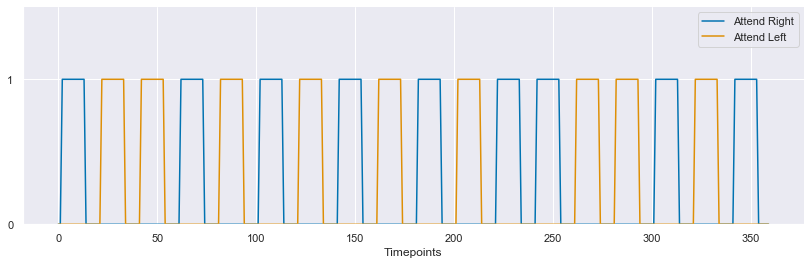

In [5]:
# Plot the stim time course. 
plt.figure(figsize=(14, 4))
plt.plot(right_stim_lag)
plt.plot(left_stim_lag)
plt.yticks([0,1])
plt.xlabel('Timepoints')

plt.legend(('Attend Right', 'Attend Left'), loc='upper right')
plt.ylim(0, 1.5)
sns.despine()

### 1.4.  Mask and Extract the Whole-brain Data <a id="mask"></a>

In other notebooks, we extracted brain data with precreated masks. Here we use a different method. Using a nilearn function we can create a mask from a dataset and then extract the data from the mask. This function can z-score the data as well. More information can be found [here](http://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html). We then plot the time course of a few voxels.

In [6]:
# Init a masker object that also standardizes the data
masker_wb = input_data.NiftiMasker(
    standardize=True,  # Are you going to zscore the data across time?
    t_r=1.5, 
    memory='nilearn_cache',  # Caches the mask in the directory given as a string here so that it is easier to load and retrieve
    memory_level=1,  # How much memory will you cache?
    verbose=0
)

# Pull out the time course for voxel
bold_wb = masker_wb.fit_transform(nii) #fit the data based on the mask for each voxel 
bold_wb_r = bold_wb[(right_stim_lag==1),:]
bold_wb_l = bold_wb[(left_stim_lag==1),:]

print('shape - whole brain bold time series: ', np.shape(bold_wb))
print('shape - whole brain bold time series, attend left : ', np.shape(bold_wb_l))
print('shape - whole brain bold time series, attend right : ', np.shape(bold_wb_r))

shape - whole brain bold time series:  (360, 43642)
shape - whole brain bold time series, attend left :  (108, 43642)
shape - whole brain bold time series, attend right :  (108, 43642)


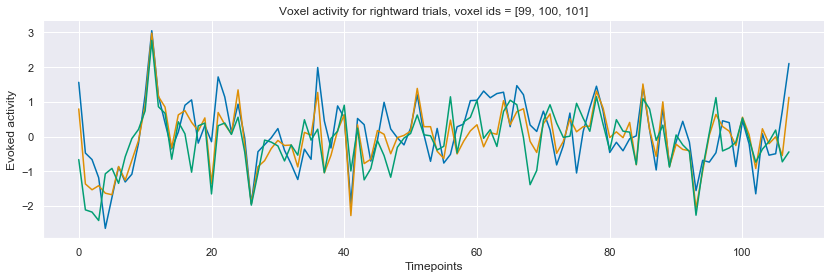

In [7]:
"""
Plot the timeseries for a few nearby voxels
"""
voxel_ids = [99,100,101]
plt.figure(figsize=(14, 4))
plt.title('Voxel activity for rightward trials, voxel ids = ' + str(voxel_ids));
plt.plot(bold_wb_r[:, voxel_ids]);
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');
sns.despine()

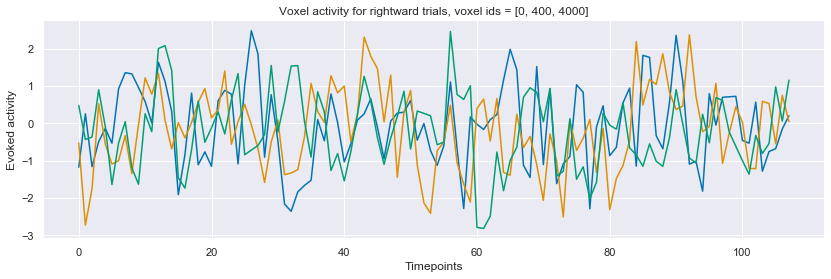

In [8]:
"""
Plot the timeseries for a random  voxels
"""
voxel_ids = [0,400,4000]
plt.figure(figsize=(14, 4))
plt.title('Voxel activity for rightward trials, voxel ids = ' + str(voxel_ids));
plt.plot(bold_wb_r[:, voxel_ids]);
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');
sns.despine()

### 2. Create a Seed  <a id="seed"></a>

At this stage, we have loaded the whole-brain data for the attend-left and attend-right conditions. To examine the effects of attention, we are going to create seed ROIs and correlate their activity with other voxels in the brain. For any voxels that are correlated with a seed ROI, we can infer that they are functionally connected.

#### 2.1 Create a Spherical ROI  <a id="ROI_sphere"></a>

Let's create an ROI to define the parahippocampal place area (PPA), a scene selective region, which is likely important since scene stimuli were presented. The data are currently in MNI space, a standardized anatomical space that allows us to compare individual anatomy to a common, averaged space and use coordinates in MNI space to identify regions (approximately) in individual participants.

This article was used to determine the center co-ordinates for the left and right PPA (use the one reported in the 'Whole-brain analyses' section): Park, S., & Chun, M. M. (2009). Different roles of the parahippocampal place area (PPA) and retrosplenial cortex (RSC) in panoramic scene perception. NeuroImage, 47(4), 1747–1756. https://doi.org/10.1016/j.neuroimage.2009.04.058. Note: they use asymmetric ROI coordinates for the left and right PPA.

In [9]:
# Specify the center of the left and right ROIs
coords_lPPA = [(27, 39, 24)]
coords_rPPA = [(30, 39, 15)]

Nilearn has some powerful tools for drawing ROIs, which allow you to flexibly identify ROIs of any shape and have multiple parameters that allow for smoothing, detrending, filtering and standardization. 
However, their parameters are highly variable so should be chosen cautiously. Most research labs have well-defined processing pipelines with these parameters set for multiple studies to avoid too much variation across studies. Here we'll play it safe and use the most basic [sphere ROI](http://nilearn.github.io/modules/generated/nilearn.input_data.NiftiSpheresMasker.html) function from nilearn.

#### 2.2 Plot the Bold Signal for the Mask  <a id="mask_signal"></a>

The average bold signal for all the voxels in the mask is computed and plotted.

In [10]:
# Init the masking object
masker_lPPA = input_data.NiftiSpheresMasker(
    coords_lPPA, 
    radius=8, standardize=True, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0
)

# Mask the epi data and get a time series for the ROI
bold_lPPA = masker_lPPA.fit_transform(nii)

# Plot the data from the seed region for both attention condition
bold_lPPA_r = bold_lPPA[right_stim_lag == 1, :]
bold_lPPA_l = bold_lPPA[left_stim_lag == 1, :]

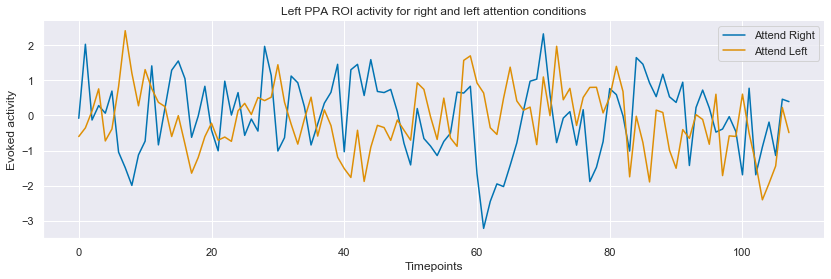

In [11]:
plt.figure(figsize=(14, 4))
plt.title('Left PPA ROI activity for right and left attention conditions')
plt.plot(bold_lPPA_r);
plt.plot(bold_lPPA_l);
plt.legend(('Attend Right', 'Attend Left'));
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');
sns.despine()

### 3. Compute the Correlation Matrix  <a id="correlation_matrix"></a>

We will again be using correlation matrices, but now for assessing functional connectivity. Each cell in these matrices reflects the correlation of the BOLD timeseries between a pair of voxels or regions, and matrices can be calculated separately for each condition or even each trial.

Below we go through a loop-based way of calculating the correlation of every voxel in the brain with the PPA seed region. We will revisit optimized ways of calculating correlations in the next exercise.

In [12]:
# Correlate seed with every brain voxel. Loop through and extract data for every voxel.
start_time = time.time()
num_voxels = bold_wb_r.shape[1]
all_corr = np.zeros((num_voxels, 1))
for v in range(num_voxels): 
    all_corr[v, 0] = np.corrcoef(bold_lPPA_r.flatten(), bold_wb_r[:, v])[0, 1]

end_time = time.time()
print('Analysis duration for %d voxels: %0.2fs' % (num_voxels, (end_time - start_time)))

Analysis duration for 43642 voxels: 3.46s


We are going to be calculating seed-based correlations throughout this notebook, so let's make a function. It is also common to transform the correlations to a [Fisher-Z score](https://en.wikipedia.org/wiki/Fisher_transformation), as the bounded nature of Pearson correlation violates certain statistical assumptions.

In [13]:
def seed_correlation(wbBold, seedBold):
    """Compute the correlation between a seed voxel vs. other voxels 
    Parameters
    ----------
    wbBold [2d array], n_stimuli x n_voxels 
    seedBold, 2d array, n_stimuli x 1

    Return
    ----------    
    seed_corr [2d array], n_stimuli x 1
    seed_corr_fishZ [2d array], n_stimuli x 1
    """
    num_voxels = wbBold.shape[1]
    seed_corr = np.zeros((num_voxels, 1))
    for v in range(num_voxels):    
        seed_corr[v, 0] = np.corrcoef(seedBold.flatten(), wbBold[:, v])[0, 1]
    # Transfrom the correlation values to Fisher z-scores    
    seed_corr_fishZ = np.arctanh(seed_corr)
    return seed_corr, seed_corr_fishZ

Seed-based correlation Fisher-z transformed: min = -0.471; max = 1.341


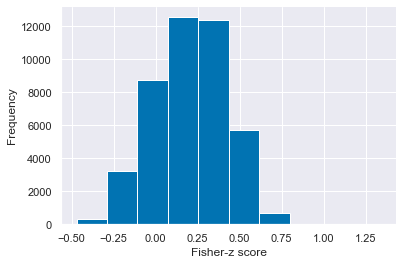

In [14]:
# Let's use the function and print out the range of results
corr_lPPA_r, corr_fz_lPPA_r = seed_correlation(bold_wb_r, bold_lPPA_r)

#correlate all right side BOLD data with left PPA of right side
print("Seed-based correlation Fisher-z transformed: min = %.3f; max = %.3f" % (
    corr_fz_lPPA_r.min(), corr_fz_lPPA_r.max()
))


# A histogram is always a useful first way of looking at your data.
plt.hist(corr_fz_lPPA_r)
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');
sns.despine()

In [15]:
# We can tranform the correlation array back to a Nifti image object that we can save
img_corr_lPPA_r= masker_wb.inverse_transform(corr_fz_lPPA_r.T)
img_corr_lPPA_r.to_filename('seed_rtstim.nii.gz')

#### 3.1 Plot the Seed Correlations  <a id="plot_seed"></a>

We plot the seed correlation with every other voxel. For better visualization, we set a threshold, showing only voxels above the threshold. Typically, thresholds are chosen based on statistical significance. Below we explore a few different thresholds

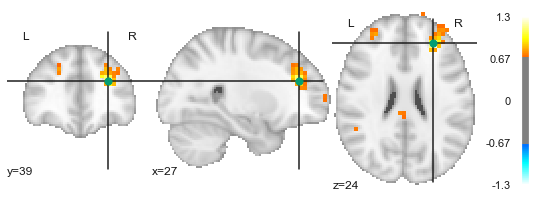

In [16]:
# Let's also visualize the correlation of the seed with every voxel
threshold = .7

# Nilearn has useful tools for plotting our results as a map
r_map_ar = plotting.plot_stat_map(
    img_corr_lPPA_r, 
    threshold=threshold,
    cut_coords=coords_lPPA[0],
)
# Add the seed
r_map_ar.add_markers(
    marker_coords=coords_lPPA, 
    marker_color='g',
    marker_size=50
)

#shows that when looking at the right side the left hippocampal place area
#is most correlated with the right frontal cortex, but also activity in 
#the left place area (opposite of spatial location)

Plot the same information using glass brain.

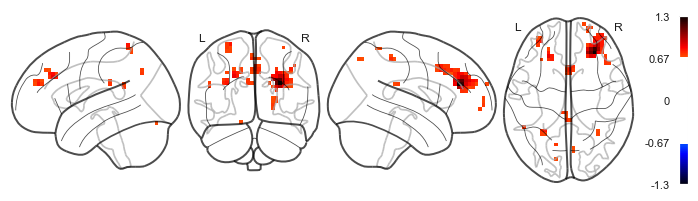

In [17]:
# Create a glass brain
plotting.plot_glass_brain(
    img_corr_lPPA_r, 
    threshold=threshold,
    colorbar=True, 
    plot_abs=False,
    display_mode='lyrz', 
);

Compute and plot the correlation with the left PPA when participants are attending to the scene in the left visual field.

**Note:** The early stages of visual processing in the brain occur in the contralateral side. If you are viewing something in your left visual field, your right visual brain areas wil show greater activity. See if you notice something similar in your results from this exercise.

In [18]:
#correlation of leftPPA with rest of brain when attending left visual field
corr_lPPA_l, corr_fz_lPPA_l = seed_correlation(bold_wb_l, bold_lPPA_l)
img_corr_lPPA_l= masker_wb.inverse_transform(corr_fz_lPPA_l.T)


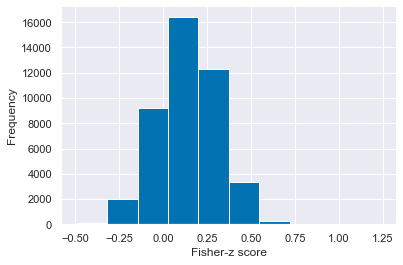

In [19]:
plt.hist(corr_fz_lPPA_l)
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');
sns.despine()

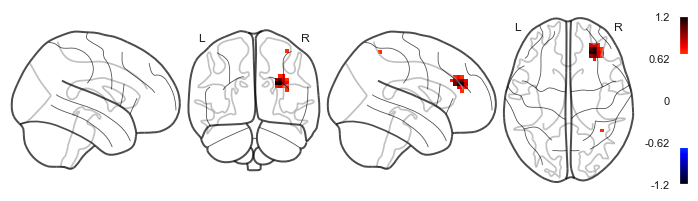

In [20]:
plotting.plot_glass_brain(
    img_corr_lPPA_l, 
    threshold=0.7,
    colorbar=True, 
    plot_abs=False,
    display_mode='lyrz', 
);
#when looking at left sife, the lPPA has correlation with 
#the right frontal cortex, and some place area 



**Explanation:** As expected when looking at visual stimuli in the left visual field there is correlated activity between the left PPA and the contralateral right frontal cortex.

Create a spherical ROI corresponding to the right PPA. Compute correlations across the whole-brain in both the 'attend left' and 'attend right' conditions and plot your results.

In [21]:
#create spherical seed 
masker_rPPA = input_data.NiftiSpheresMasker(
    coords_rPPA, 
    radius=8, standardize=True, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0
)

# Mask the epi data and get a time series for the ROI
bold_rPPA = masker_rPPA.fit_transform(nii)

# Plot the data from the seed region for both attention condition
bold_rPPA_r = bold_rPPA[right_stim_lag == 1, :]
bold_rPPA_l = bold_rPPA[left_stim_lag == 1, :]


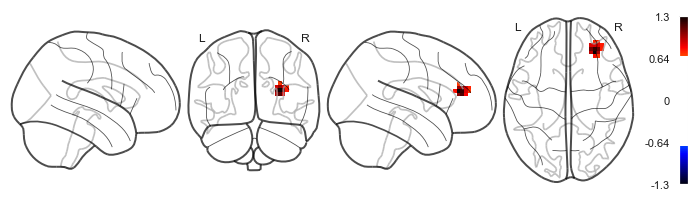

In [22]:
#correlate with left side 
corr_rPPA_l, corr_fz_rPPA_l = seed_correlation(bold_wb_l, bold_rPPA_l)

#correlate the rPPA under left condition with rest of brain under left cond
img_corr_rPPA_l= masker_wb.inverse_transform(corr_fz_rPPA_l.T)

#expect to see correlation with PPA on right side 
plotting.plot_glass_brain(
    img_corr_rPPA_l, 
    threshold=0.7,
    colorbar=True, 
    plot_abs=False,
    display_mode='lyrz', 
);


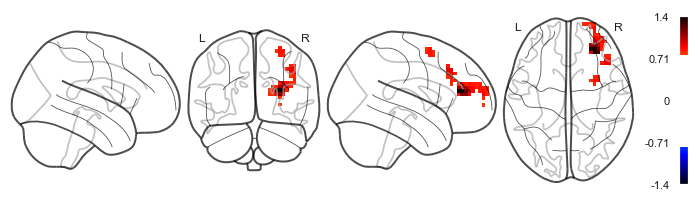

In [23]:
corr_rPPA_r, corr_fz_rPPA_r = seed_correlation(bold_wb_r, bold_rPPA_r)

img_corr_rPPA_r= masker_wb.inverse_transform(corr_fz_rPPA_r.T)

plotting.plot_glass_brain(
    img_corr_rPPA_r, 
    threshold=0.8,
    colorbar=True, 
    plot_abs=False,
    display_mode='lyrz', 
);

#lots of correlation with the rPPA in the right cortex for right condition

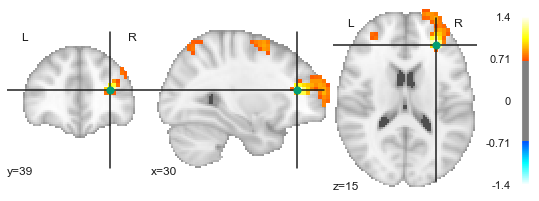

In [24]:
# Plot results as a map
r_map_ar = plotting.plot_stat_map(
    img_corr_rPPA_r, 
    threshold=threshold,
    cut_coords=coords_rPPA[0],
)
# Add the seed
r_map_ar.add_markers(
    marker_coords=coords_rPPA, 
    marker_color='g',
    marker_size=50
)


**Explanation** The right frontal cortex appears to have strong correlation with the right PPA regardless of the side of the visual stimulus.

### 4. Creating a Seed from an Atlas  <a id="ROI_atlas"></a>

In addition to creating our own seed ROIs, we can use available atlases to extract ROIs. Nilearn provides an easy way to accomplish this.

Atlas path: /Users/aratzan/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz


Harvard-Oxford cortical atlas


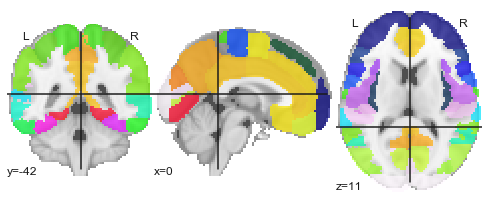

In [25]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps

# This is where the atlas is saved.
print("Atlas path: " + atlas_filename + "\n\n")

# Plot the ROIs
plotting.plot_roi(atlas_filename);
print('Harvard-Oxford cortical atlas')

In [26]:
# Create a Pandas dataframe of the atlas data for easy inspection.
atlas_pd = pd.DataFrame(atlas)
print(atlas_pd['labels'])

0                                            Background
1                                          Frontal Pole
2                                        Insular Cortex
3                                Superior Frontal Gyrus
4                                  Middle Frontal Gyrus
5             Inferior Frontal Gyrus, pars triangularis
6              Inferior Frontal Gyrus, pars opercularis
7                                      Precentral Gyrus
8                                         Temporal Pole
9            Superior Temporal Gyrus, anterior division
10          Superior Temporal Gyrus, posterior division
11             Middle Temporal Gyrus, anterior division
12            Middle Temporal Gyrus, posterior division
13         Middle Temporal Gyrus, temporooccipital part
14           Inferior Temporal Gyrus, anterior division
15          Inferior Temporal Gyrus, posterior division
16       Inferior Temporal Gyrus, temporooccipital part
17                                    Postcentra

In [27]:
# Create a masker object that we can use to select ROIs
masker_ho = NiftiLabelsMasker(labels_img=atlas_filename)
print(masker_ho.get_params())

# Apply our atlas to the Nifti object so we can pull out data from single parcels/ROIs
bold_ho = masker_ho.fit_transform(nii)
print('shape: parcellated bold time courses: ', np.shape(bold_ho))

{'background_label': 0, 'detrend': False, 'dtype': None, 'high_pass': None, 'labels_img': '/Users/aratzan/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz', 'low_pass': None, 'mask_img': None, 'memory': Memory(location=None), 'memory_level': 1, 'resampling_target': 'data', 'smoothing_fwhm': None, 'standardize': False, 't_r': None, 'verbose': 0}
shape: parcellated bold time courses:  (360, 48)


Use Nilearn to calculate the timecourse of activity across all of the ROIs that are supplied to the masker object.

Parcellated data shape (time points x num ROIs)
All time points   (360, 48)
Rightward attention trials:  (108, 48)
Posterior PPC (region 35) rightward attention trials:  (108, 1)


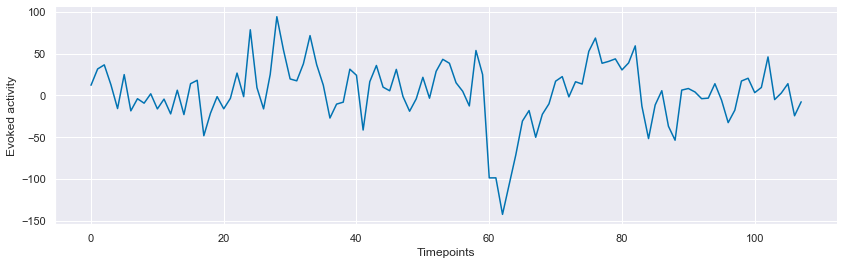

In [28]:
# Get data for rightward attention only
bold_ho_r = bold_ho[(right_stim_lag==1),:]

# What does our data structure look like?
print("Parcellated data shape (time points x num ROIs)")
print("All time points  ", bold_ho.shape)
print("Rightward attention trials: ", bold_ho_r.shape)

# Pull out a single ROI corresponding to the posterior parahippocampal cortex
roi_id = 34
bold_ho_pPHG_r = np.array(bold_ho_r[:, roi_id])
bold_ho_pPHG_r = bold_ho_pPHG_r.reshape(bold_ho_pPHG_r.shape[0],-1)
print("Posterior PPC (region 35) rightward attention trials: ", bold_ho_pPHG_r.shape)

plt.figure(figsize=(14,4))
plt.plot(bold_ho_pPHG_r)
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');
sns.despine()

PHG correlation Fisher-z transformed: min = -0.656; max = 1.088


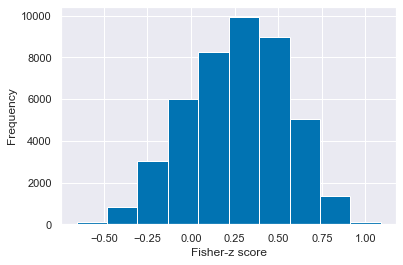

In [29]:
# Like before we want to correlate the whole brain time course with the seed we have pulled out

corr_pPHG_r, corr_fz_pPHG_r = seed_correlation(
    bold_wb_r, bold_ho_pPHG_r
) 

# Print the range of correlations.
print("PHG correlation Fisher-z transformed: min = %.3f; max = %.3f" % (
    corr_fz_pPHG_r.min(), corr_fz_pPHG_r.max())
)

# Plot a histogram
plt.hist(corr_fz_pPHG_r)
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');

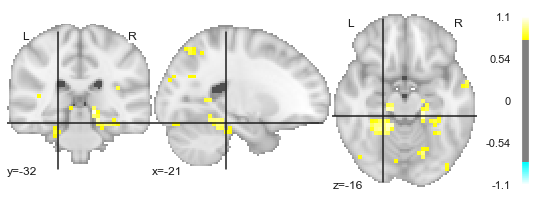

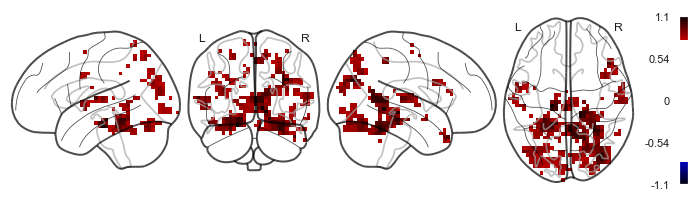

In [30]:
# Map back to the whole brain image
img_corr_pPHG_r = masker_wb.inverse_transform(
    corr_fz_pPHG_r.T
)

threshold = .8 

# Find the cut coordinates of this ROI, using parcellation.
# This function takes the atlas path and the hemisphere and outputs all centers of the ROIs
roi_coords = plotting.find_parcellation_cut_coords(atlas_filename,label_hemisphere='left')

# Pull out the coordinate for this ROI
roi_coord = roi_coords[roi_id,:]

# Plot the correlation as a map on a standard brain. 
# For comparison, we also plot the position of the sphere we created ealier.
h2 = plotting.plot_stat_map(
    img_corr_pPHG_r, 
    threshold=threshold,
    cut_coords=roi_coord,
)

# Create a glass brain
plotting.plot_glass_brain(
    img_corr_pPHG_r, 
    threshold=threshold,
    colorbar=True, 
    display_mode='lyrz', 
    plot_abs=False
)

#### 4.1 Compute Connectivity Across Parcels <a id="parcel_corr"></a>

In addition to one ROI, we can compute correlations across multiple brain regions. Nilearn has a [function](http://nilearn.github.io/modules/reference.html#module-nilearn.connectome) to do this quite easily. This will be useful to study attention in different brain regions.


In [31]:
# Alternatively, we could use Nilearn's own plotting function
plotting.plot_matrix(
    corr_mat_ho_r, 
    cmap='RdYlBu_r', 
    figure=(11, 10), 
    labels=atlas.labels[1:], 
)

NameError: name 'corr_mat_ho_r' is not defined

**Exercise 5:**<a id="ex5"></a> It was mentioned earlier that the parietal cortex modulates sensory processing. Let's examine this. Use a parcel from the **superior parietal lobe** as a seed and compute the **voxelwise** correlation across the brain for the attend left and attend right conditions. 

When plotting the data, use `plotting.find_parcellation_cut_coords` to find the center of each ROI. Then use these coordinates to specify the `cut_coords` that you want to center your code on. 

Also note, that roi_id does not align with the ROI names in the panda data frame print above. Specifically, each roi_id is 1 less than the number reported in this table. That is because an ROI is not made for the background. 

In [ ]:
# Insert code here

#parcel from superior parietal lobe and compute voxelwise correlation
#18 in dataframe
bold_ho_r = bold_ho[(right_stim_lag==1),:]

roi_id = 17
bold_ho_SPL_r = np.array(bold_ho_r[:, roi_id])
bold_ho_SPL_r = bold_ho_SPL_r.reshape(bold_ho_SPL_r.shape[0],-1)

#correlate with right
corr_SPL_r, corr_fz_SPL_r = seed_correlation(
    bold_wb_r, bold_ho_SPL_r
) 

img_corr_SPL_r = masker_wb.inverse_transform(
    corr_fz_SPL_r.T
)

roi_coords = plotting.find_parcellation_cut_coords(atlas_filename,label_hemisphere='right')

# Pull out the coordinate for this ROI
roi_coord = roi_coords[roi_id,:]

# Plot the correlation as a map on a standard brain. 
# For comparison, we also plot the position of the sphere we created ealier.
h2 = plotting.plot_stat_map(
    img_corr_SPL_r, 
    threshold=threshold,
    cut_coords=roi_coord,
)

# Create a glass brain
plotting.plot_glass_brain(
    img_corr_SPL_r, 
    threshold=threshold,
    colorbar=True, 
    display_mode='lyrz', 
    plot_abs=False
)

#high correlation with rest of brain activity for attend right 



In [ ]:
bold_ho_l = bold_ho[(left_stim_lag==1),:]

roi_id = 17
bold_ho_SPL_l = np.array(bold_ho_l[:, roi_id])
bold_ho_SPL_l = bold_ho_SPL_l.reshape(bold_ho_SPL_l.shape[0],-1)

corr_SPL_l, corr_fz_SPL_l = seed_correlation(
    bold_wb_l, bold_ho_SPL_l
) 

img_corr_SPL_l = masker_wb.inverse_transform(
    corr_fz_SPL_l.T
)

roi_coords = plotting.find_parcellation_cut_coords(atlas_filename,label_hemisphere='right')

# Pull out the coordinate for this ROI
roi_coord = roi_coords[roi_id,:]

# Plot the correlation as a map on a standard brain. 
# For comparison, we also plot the position of the sphere we created ealier.
h2 = plotting.plot_stat_map(
    img_corr_SPL_l, 
    threshold=threshold,
    cut_coords=roi_coord,
)

# Create a glass brain
plotting.plot_glass_brain(
    img_corr_SPL_l, 
    threshold=threshold,
    colorbar=True, 
    display_mode='lyrz', 
    plot_abs=False
)

#less correlation with left side attention


### 5. Background Connectivity <a id="back_conn"></a>

There is a potential problem in analyzing functional connectivity during tasks. Consider brain regions A and B. Let's assume that our stimuli activate both regions. If we were to examine correlations between the regions, they would have strong connectivity, but not because they are necessarily communicating or interacting in any way. Rather, they share the stimulus as a third variable. One solution is to regress out the stimulus-evoked responses from our signal and re-examine the correlations between regions. If region A and B are still correlated, we are on more solid footing that they are functionally connected during the task. Insofar as this "background connectivity" differs between task conditions (e.g., attend left vs. right), we can conclude that the task is modulating the scaffold of noise correlations in the brain. To learn more about background connectivity, see this [review](https://doi.org/10.1126/science.1238409).

In background connectivity analysis, stimulus-driven activation is not the desired effect of interest, but potentially a confound. Thus, now we need to remove "stimulus confounds" before continuing. Lucky for us, the dataset in the directory `../processed_data/background/` has already had the evoked activity and other nuisance variables regressed out. We'll repeat the previous analyses for the left PPA on these data.

In [ ]:
# Load in the data
sub = 'sub01'
epi_in_mcg = (dir_motion_background + '%s.nii.gz' % (sub))

# Get the seed data
bold_lPPA_mcg = masker_lPPA.fit_transform(epi_in_mcg)
bold_lPPA_r_mcg = bold_lPPA_mcg[right_stim_lag==1,:]
bold_lPPA_l_mcg = bold_lPPA_mcg[left_stim_lag==1,:]

# Get the whole brain data
boldWB_mcg = masker_wb.fit_transform(epi_in_mcg)
boldWB_r_mcg = boldWB_mcg[right_stim_lag==1,:] 
boldWB_l_mcg = boldWB_mcg[left_stim_lag==1,:] 

# plot the data
plt.figure(figsize=(14,4))
plt.plot(bold_lPPA_r_mcg)
plt.plot(bold_lPPA_l_mcg)
plt.legend(('Attend Right', 'Attend Left'));
plt.ylabel('BOLD signal, standardized')
plt.xlabel('TRs of right attention blocks')
plt.title('Background activity in seed region')
sns.despine()

In [ ]:
# Calculate the voxelwise seed-based correlation
corr_lPPA_r_mcg, corr_fz_lPPA_r_mcg  = seed_correlation(boldWB_r_mcg, bold_lPPA_r_mcg)
corr_lPPA_l_mcg, corr_fz_lPPA_l_mcg  = seed_correlation(boldWB_l_mcg, bold_lPPA_l_mcg)

# Make an image 
img_corr_fz_lPPA_r_mcg = masker_wb.inverse_transform(corr_fz_lPPA_r_mcg.T)
img_corr_fz_lPPA_l_mcg = masker_wb.inverse_transform(corr_fz_lPPA_l_mcg.T)

print('PHG correlation Fisher-z transformed')
print("Right: min = %.3f; max = %.3f" % (
    corr_fz_lPPA_r_mcg.min(), corr_fz_lPPA_r_mcg.max()))
print("Left: min = %.3f; max = %.3f" % (
    corr_fz_lPPA_l_mcg.min(), corr_fz_lPPA_l_mcg.max()))

In [ ]:
# Plot the correlation of each voxel in the brain with the seed
threshold = .8
vmax = np.max(np.stack([corr_fz_lPPA_r_mcg, corr_fz_lPPA_l_mcg]))

f, axes = plt.subplots(2, 2, figsize = (16, 7))

# left
axes[0,0].set_title('Attend left, lPPA')
r_map = plotting.plot_stat_map(
    img_corr_fz_lPPA_l_mcg, 
    threshold=threshold, vmax=vmax, 
    cut_coords=coords_lPPA[0], 
    axes=axes[0,0]
)
r_map.add_markers(
    marker_coords=coords_lPPA, 
    marker_color='g',
    marker_size=50
)
plotting.plot_glass_brain(
    img_corr_fz_lPPA_l_mcg, 
    threshold=threshold, vmax=vmax, 
    colorbar=True, 
    display_mode='lyrz', 
    plot_abs=False, 
    axes=axes[1,0]
)

# right
axes[0,1].set_title('Attend right, lPPA')
r_map = plotting.plot_stat_map(
    img_corr_fz_lPPA_r_mcg, 
    threshold=threshold, vmax=vmax, 
    cut_coords=coords_lPPA[0], 
    axes=axes[0,1]
)
r_map.add_markers(
    marker_coords=coords_lPPA, 
    marker_color='g',
    marker_size=50
)
plotting.plot_glass_brain(
    img_corr_fz_lPPA_r_mcg, 
    threshold=threshold, vmax=vmax, 
    colorbar=True, 
    display_mode='lyrz', 
    plot_abs=False, 
    axes=axes[1,1]
)

**Exercise 6:**<a id="ex6"></a> Compare background connectivity (above) to the original left PPA spherical ROI result (from [3.1](#plot_seed)). Explain why this difference might exist.

**A:** More noise in the original correlational connectivity 

Make a correlation matrix with the background connectivity data for one condition.

In [ ]:
# Parcellate the time course to get the background connectivity parcels
parcel_time_series_mcg = masker_ho.fit_transform(epi_in_mcg)
boldParcel_rightstim_mcg = parcel_time_series_mcg[right_stim_lag==1, :]

correlation_matrix_mcg = correlation_measure.fit_transform([boldParcel_rightstim_mcg])[0]

# Remove the diagonal for visualization (guaranteed to be 1.0)
np.fill_diagonal(correlation_matrix_mcg, np.nan)

# Plot the correlation matrix
fig=plt.figure(figsize=(11, 10))

# The labels we have start with the background (0), hence we skip the first label
plt.title('Background connnectivity correlation for parcellation')
plt.imshow(correlation_matrix_mcg, interpolation='None', cmap='RdYlBu_r')
plt.yticks(range(len(atlas.labels)), atlas.labels[1:]);
plt.xticks(range(len(atlas.labels)), atlas.labels[1:], rotation=90);
plt.colorbar()

**Exercise 7:**<a id="ex7"></a> Use a different atlas (use [`datasets.fetch_atlas_`](http://nilearn.github.io/modules/reference.html#module-nilearn.datasets) to look through other available atlases) and recompute the background connectivity matrix for both attend left and attend right conditions. Use an atlas that distinguishes ROIs between the left and right hemispheres and rearrange the labels so that all the ROIs from a hemisphere are grouped. What structure do you notice in the correlation matrix if any and what does it mean?

**A:**

In [ ]:
# Insert code here

### 6. Group Analyses <a id="group"></a>


**Exercise 8:**<a id="ex8"></a> Calculate and store the two matrices computed in [Exercise 7](#ex7) (functional connectivity separately for each attention condition) for all 30 participants. Plot the average across participants for each condition.

*Hint:* We recommend that you make helper functions that encapsulate some of the steps from above. For instance make a script that gets the timing information for each participant, like we did in [1.1](#time_shift) and another function to take in an atlas, data and the stimulus labels to create a correlation matrix. Then loop through the participants and stack the matrices you create (since these are 2D matrices we want to stack in depth, which you can use `np.dstack` for).

In [ ]:
# Insert code here


**Exercise 9:**<a id="ex9"></a> Taking the data from Ex 8, calculate the difference between the left attention and right attention correlation matrix for each participant (if they are stacked matrices then you only need to subtract the 3d arrays). You should now have 30 difference matrices. This allows you to conduct a simple statistical test of how reliably left vs. right attention affects background connectivity between parcels in the sample. We will use a one-sample t-test for this purpose (`stats.ttest_1samp`), which takes in the difference matrix for each participant and the `popmean`. The `popmean` for this test is 0, representing the value we are trying to be different from. 

Summarize in words which regions' connectivity (if any) distinguishes attention conditions.


In [ ]:
# Insert code here


**Plotting a Connectome** <a id="connectome"></a>

Nilearn has some beautiful tools for plotting connectomes. [`plotting.plot_connectome`](http://nilearn.github.io/modules/generated/nilearn.plotting.plot_connectome.html) takes in the node by node correlation matrix and a node by coordinate matrix and then creates a connectome. Thresholds can be used to only show strong connections. 

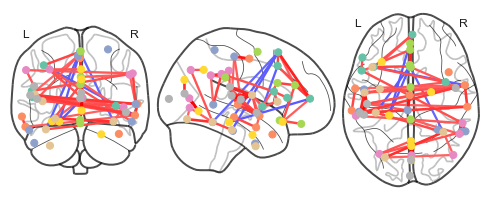

In [74]:
# Load the atlas
atlas_nii = nib.load(atlas_filename)
atlas_data = atlas_nii.get_data()
labels = np.unique(atlas_data)

# Iterate through all of the ROIs
coords = []
for label_id in labels:
    
    # Skip the background
    if label_id == 0:
        continue
        
    # Pull out the ROI of within the mask    
    roi_mask = (atlas_data == label_id)
    
    # Create as a nifti object so it can be read by the cut coords algorithm
    nii = nib.Nifti1Image(roi_mask.astype('int16'), atlas_nii.affine)
    
    # Find the centre of mass of the connectome
    coords.append(plotting.find_xyz_cut_coords(nii))
    
# Plot the connectome
plotting.plot_connectome(correlation_matrix_mcg, coords, edge_threshold='95%')

**Novel Contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

## Contributions <a id="contributions"></a>

B. Hutchinson provided data and provided initial code  
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 3/15/18  
Q. Lu add solution   
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis implemented updates from cmhn-s19